## Resources
https://www.diva-portal.org/smash/get/diva2:1487838/FULLTEXT01.pdf
https://www.researchgate.net/publication/334671542_Coverage_Path_Planning_Optimization_Based_on_Q-learning_Algorithm
https://link.springer.com/article/10.1007/s00521-023-08735-2 \
https://ieeexplore.ieee.org/document/10129591 \
https://ieeexplore.ieee.org/document/10064303

## Plan
* Combine PredatorPrey with a swarm
* Potentially augemnt PP to avoid other members of the swarm?

## Improvements
* If an agent cannot see a univisited location ask other agents. Move towards named location
* Fix backtrack to remeber location. If it sees a location which is earlier in the loop can jump to it.
* Discover the environment with the agents

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

import time
import random
import copy

## Environments (Planet)

In [2]:
# U D L R
ACTIONS = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}
class Planet(object):
    def __init__(self, planet_width, num_robots):
        # start with defining your planet
        self.planet_width = planet_width
        self.planet_edge = planet_width - 1
        self.planet = np.zeros((planet_width, planet_width)).astype(int)
        
        #Traps
        #self.planet[3, 4] = 1
        #self.planet[2, 1] = 1
        #self.planet[7, 2] = 1
        #self.planet[4, 8] = 1
        
        #Robots
        self.num_robots = num_robots
        self.robot_positions = []
        self.prev_robot_locations = np.zeros((num_robots, 4)).astype(int)
        self.agent_setup()
               
        self.steps = 0 # contains num steps robots took
        self.allowed_states = None # for now, this is none
        self.construct_allowed_states() 
    
    def agent_setup(self):
        for r in range(self.num_robots):
            found = False
            val_r = r
            while found == False:  
                temp_y = val_r // self.planet_width
                temp_x = val_r % self.planet_width
                if self.planet[temp_y, temp_x] == 0:
                    found = True
                else:
                    val_r += 1
                    
            self.robot_positions.append((temp_y, temp_x))
            self.planet[temp_y, temp_x] = 2
            self.prev_robot_locations[r][0] = temp_y
            self.prev_robot_locations[r][1] = temp_x
            self.prev_robot_locations[r][2] = temp_y
            self.prev_robot_locations[r][3] = temp_x
    
    def is_allowed_move(self, state, action):
        y, x = state
        y += ACTIONS[action][0]
        x += ACTIONS[action][1]
        # moving off the board
        if y < 0 or x < 0 or y > self.planet_edge or x > self.planet_edge:
             return False
        # moving into empty space
        elif self.planet[y, x] != 0:
            return False
        else:
            return True
        
    def construct_allowed_states(self):
        allowed_states = {}
        for y, row in enumerate(self.planet):
            for x, col in enumerate(row):
                # iterate through all valid spaces
                if self.planet[(y,x)] != 1:
                    allowed_states[(y,x)] = []
                    for action in ACTIONS:
                        if self.is_allowed_move((y, x), action):
                            allowed_states[(y,x)].append(action)
        self.allowed_states = allowed_states
        
    def update_planet(self, action, robot_num):
        y, x = self.robot_positions[robot_num]
        old_y, old_x = self.robot_positions[robot_num]
        y += ACTIONS[action][0]
        x += ACTIONS[action][1]
        self.planet[y, x] = 2
        self.planet[old_y, old_x] = 0
        self.robot_positions[robot_num] = (y, x)
        
    def invalid_move(self, action, robot_num):
        y, x = self.robot_positions[robot_num]
        y += ACTIONS[action][0]
        x += ACTIONS[action][1]
        return (y, x)  
                
    def is_game_over(fully_covered):
        return fully_covered
    
    def get_distance(self, prey, pred):
        prey_location = self.robot_positions[prey]
        pred_location = self.robot_positions[pred]
        distance = math.sqrt(math.pow((prey_location[0]-pred_location[0]), 2) + math.pow((prey_location[1]-pred_location[1]), 2))
        return distance
    
    def neighbour_distance(self, prey):
        min_dist = 1e10
        max_dist = 0
        location = self.robot_positions[prey]
        action = 0
        while action < 4:
            temp_y, temp_x = location
            temp_y += ACTIONS[action][0]
            temp_x += ACTIONS[action][1]
            if not (temp_y < 0 or temp_x < 0 or temp_y > planet.planet_edge or temp_x > planet.planet_edge):
                    for i in range(self.num_robots):
                        if not (i == prey):
                            distance = self.get_distance(prey, i)
                            if (distance > max_dist):
                                max_dist = distance
                            if (distance < min_dist):
                                min_dist = distance
            action += 1
        return min_dist, max_dist
        
    def give_reward(self, state_history, robot_num, visited_locations):
        # Parameters 
        predator_weight = 1.5
        smoothness_weight = 1
        boundary_weight = 1
        
        #Updated Location - Location the reward is being calculated for
        location = self.robot_positions[robot_num]
        
        # If new location get specialised reward
        if location not in visited_locations:
            
            # Predator-Prey
            # Distance between agents neighbours and the predator (other agents)
            min_dist, max_dist = self.neighbour_distance(robot_num)
            # Closest agent
            current_dist = 1e10
            for i in range(self.num_robots):
                if not (i == robot_num):
                    distance = self.get_distance(robot_num, i)
                    if (distance < current_dist):
                        current_dist = distance
            
            predator_reward = (current_dist - min_dist) / (max_dist - min_dist)
            
            
            # Smoothness - Reward Function   
            # 2 prev - 1 prev - curr
            prev_2_y = self.prev_robot_locations[robot_num][0]
            prev_2_x = self.prev_robot_locations[robot_num][1]
            prev_1_y = self.prev_robot_locations[robot_num][2]
            prev_1_x = self.prev_robot_locations[robot_num][3]
           
            vector_1_y = prev_2_y - prev_1_y
            vector_1_x = prev_2_x - prev_1_x
            
            vector_2_y = prev_1_y - location[0]
            vector_2_x = prev_1_x - location[1]
            
            if(vector_1_y == 0 and vector_1_x == 0) or (vector_2_y == 0 and vector_2_x == 0):
                #Didnt Move either this turn or last, therefore no direction to maintain
                smoothness_reward = 1
            elif(vector_1_y == vector_2_y) and (vector_1_x == vector_2_x):
                # Vectors are the same therefore moved in the same direction
                smoothness_reward = 1
            else:
                smoothness_reward = 0.5
                
            # Boundary - Reward Function
            # Number of neighbours the location has
            total_neighbours = 0
            unvisited_neighbours = 0
            action = 0
            while action < 4:
                temp_y, temp_x = location
                temp_y += ACTIONS[action][0]
                temp_x += ACTIONS[action][1]
                if not (temp_y < 0 or temp_x < 0 or temp_y > planet.planet_edge or temp_x > planet.planet_edge):
                    total_neighbours += 1
                    if not ((temp_y, temp_x) in visited_locations):
                        unvisited_neighbours += 1
                action += 1
            
            boundary_reward = (total_neighbours - unvisited_neighbours) / total_neighbours
            
            
            # Combined Reward
            reward = (predator_weight * predator_reward) + (smoothness_weight * smoothness_reward) + (boundary_weight * boundary_reward)
            
        else:
            reward = -0.05
        
        # Edit prev locations
        self.prev_robot_locations[robot_num][0] = self.prev_robot_locations[robot_num][2]
        self.prev_robot_locations[robot_num][1] = self.prev_robot_locations[robot_num][3]
        self.prev_robot_locations[robot_num][2] = location[0]
        self.prev_robot_locations[robot_num][3] = location[1]
        
        return reward
    def get_state_and_reward(self, state_history, robot_num, visited_locations):
        return self.robot_positions[robot_num], self.give_reward(state_history, robot_num, visited_locations)

## Agent Class (Robots)

In [3]:
# U D L R
ACTIONS = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}
class Agent(object):
    def __init__(self, states, alpha=0.15, gamma = 0.9, random_factor=0.2, robot_num=9, planet_width=6):       
        self.initial_alpha = alpha
        self.alpha = alpha
        self.learning_decay = 1
        self.gamma = gamma
        self.random_factor = random_factor
        self.robot_num = robot_num
        
        self.state_history = [] #State, action 
        self.backtrack = -1 #Used for backtracking along path
        self.can_backtrack = True
        
        # start the rewards table
        self.qtable = np.zeros(((planet_width*planet_width), 4)).tolist()
        
        self.seen_locations = []

    def update_state_history(self, state, action):
        self.state_history.append((state, action))
        
    def reset_backtrack(self):
        self.state_history = []
        self.backtrack = -1
        self.can_backtrack = True
        
    def learn(self, state, reward, action, next_state, episode, planet_width):
        a = self.alpha
        g = self.gamma
        y, x = state
        state_index = (y * planet_width) + x
        current_qReward =  self.qtable[state_index][action]
        Ny, Nx = next_state       
        next_state_index = (Ny * planet_width) + Nx
        self.qtable[state_index][action] = current_qReward + (a * (reward + (g * (max(self.qtable[next_state_index]))) - current_qReward))
        self.random_factor = self.random_factor*0.9995 # decrease random_factor
        if self.random_factor <= 0.001:
            self.random_factor = 0.001 
        self.alpha = (1/(1+self.learning_decay*episode))*self.initial_alpha
            
    def choose_action(self, state, allowed_moves, state_history, planet, visited_locations):        
        next_move = None
        n = np.random.uniform()
        # Random
        if self.backtrack == -1 and n < self.random_factor:
            if not allowed_moves:
                valid = False
            else:
                next_move = np.random.choice(allowed_moves)
                valid = True
        # Choose best action
        else:
            y, x = state
            state_index = (y * planet.planet_width) + x
            
            unvisited_actions = []
            
            # Compile actions that vist unknown locations
            action = 0
            while action < 4:
                temp_y, temp_x = state
                temp_y += ACTIONS[action][0]
                temp_x += ACTIONS[action][1]
                if not (temp_y < 0 or temp_x < 0 or temp_y > planet.planet_edge or temp_x > planet.planet_edge):
                    if planet.planet[(temp_y,temp_x)] == 0: 
                        if not ((temp_y, temp_x) in visited_locations):
                            action_reward = self.qtable[state_index][action]
                            unvisited_actions.append((action_reward, action))
                action += 1
            
            #If no unvisited neighbours back tracks
            if unvisited_actions == []:
                # Needs to take into account that backtracked state will be part of the history
                # Check the list isnt over
                if (len(state_history) >= -self.backtrack and self.can_backtrack == True):
                    prev_entry = state_history[self.backtrack]
                    prev_action = state_history[self.backtrack][1] # Need the action to move to this state
                    self.backtrack -= 2 # Increment backtrack
                    if prev_action == 0:
                        next_move = 1
                    elif prev_action == 1:
                        next_move = 0
                    elif prev_action == 2:
                        next_move = 3
                    elif prev_action == 3:
                        next_move = 2
                    valid = True
                else:
                    self.can_backtrack = False
                    # Compile all possible actions
                    action = 0
                    while action < 4:
                        temp_y, temp_x = state
                        temp_y += ACTIONS[action][0]
                        temp_x += ACTIONS[action][1]
                        if not (temp_y < 0 or temp_x < 0 or temp_y > planet.planet_edge or temp_x > planet.planet_edge):
                            if planet.planet[(temp_y,temp_x)] == 0: 
                                action_reward = self.qtable[state_index][action]
                                unvisited_actions.append((action_reward, action))
                        action += 1                   
                    # If still no possible moves
                    if unvisited_actions == []:
                        valid = False
                    else:
                        action_label = unvisited_actions[unvisited_actions.index(max(unvisited_actions))]
                        unvisited_actions.remove(action_label)
                        next_move = action_label[1]    
                        valid = True                       
                
            else:
                self.backtrack = -1
                self.can_backtrack = True
                action_label = unvisited_actions[unvisited_actions.index(max(unvisited_actions))]
                unvisited_actions.remove(action_label)
                next_move = action_label[1]    
                valid = True
                
        return next_move, valid           

## Server

In [4]:
class Server(object):
    def __init__(self):
        # Variables
        self.fully_covered = False
        
        # Track visited locations
        self.no_visited_locations = 0
        self.visited_locations = []
        
    def reset_count(self):
        # Reinitialise varaibles
        self.fully_covered = False
        self.no_visited_locations = 0
        self.visited_locations = []

## Learning Loop

Hello
Intialised Planet
[[2 2 2 2 2 2 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
Episode 0
Completed 0
Episode 500
Completed 500
Episode 999
Epsilon 0.001
Completed 500
Visited Locations: 64 Steps: 12


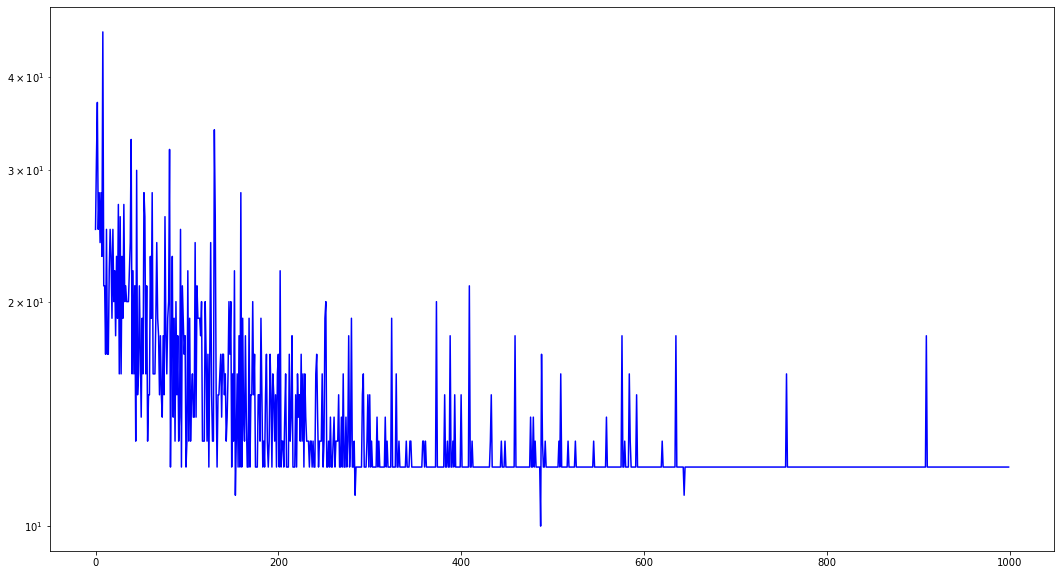

In [9]:
if __name__ == '__main__':  
    # Hyper Parameters
    Learning_Rate = 0.001
    Error_Rate = 0.9
    Epsilon = 0.5
    Episodes = 1000
    
    # Simulation Parameters
    planet_size = 8
    num_robots = 6
    Movement_Budget = 500 #planet_size * 100    
    completed_count = 0
    
    print("Hello")
    
    planet = Planet(planet_width=planet_size, num_robots=num_robots)   
    server = Server()
    print("Intialised Planet")
    print(planet.planet)
    
    # Initialise Robots 
    swarm = []
    for r in range(num_robots):
        temp_robot = Agent(planet.planet, alpha=Learning_Rate, gamma=Error_Rate, random_factor=Epsilon, robot_num=r, planet_width=planet.planet_width)
        swarm.append(temp_robot)
    
    moveHistory = []
    epsilonHistory = []
    
    # Possible visitable locations
    visitable_locations = (np.size(planet.planet) - np.count_nonzero(planet.planet == 1))
    
    for i in range(Episodes):
        if i % 500 == 0:                    
            print("Episode",i)
            print("Completed", completed_count) 
            completed_count = 0
        
        #Intialise Variables
        movementBudget = Movement_Budget
        server.reset_count()
        # vist all starting locations
        for r in range(num_robots):
            robot = swarm[r]
            robot.reset_backtrack()
            if planet.robot_positions[r] not in server.visited_locations:
                server.visited_locations.append(planet.robot_positions[r])
                server.no_visited_locations += 1
        
        while not server.fully_covered:  
            for n in range(num_robots):
                robot = swarm[n]
                sHistory = robot.state_history
                #state, _ = planet.get_state_and_reward(sHistory, robot.robot_num, server.visited_locations) # get the current state
                state = planet.robot_positions[robot.robot_num]
                action, valid = robot.choose_action(state, planet.allowed_states[state], sHistory, planet, server.visited_locations) # choose an action (explore or exploit)
                if valid:
                    planet.update_planet(action, robot.robot_num) # update the planet according to the action
                    next_state, reward = planet.get_state_and_reward(sHistory, robot.robot_num, server.visited_locations) # get the new state and reward    
                    robot.update_state_history(next_state, action)
                    if next_state not in server.visited_locations:
                        server.visited_locations.append(next_state)
                        server.no_visited_locations += 1
                        if server.no_visited_locations >= visitable_locations:
                            completed_count += 1
                            reward = 10
                    robot.learn(state, reward, action, next_state, i, planet.planet_width)
                    
            planet.steps += 1
            movementBudget -= 1        
            if server.no_visited_locations >= visitable_locations: 
                server.fully_covered = True
            elif movementBudget <= 0:
                # End the episode if the movement budget runs out
                server.fully_covered = True        

        moveHistory.append(planet.steps) # get a history of number of steps taken to plot later
        epsilonHistory.append(robot.random_factor)
        
        # Intialise the variables
        planet = Planet(planet_width=planet_size, num_robots=num_robots) 
        

print("Episode",i)
print("Epsilon",robot.random_factor)
print("Completed", completed_count) 
        
print("Visited Locations:", server.no_visited_locations, "Steps:", moveHistory[-1])  
plt.figure(figsize=(18, 10))
plt.semilogy(moveHistory, color="b")
#plt.semilogy(epsilonHistory, color="r")
plt.show()

## Testing and Simulation

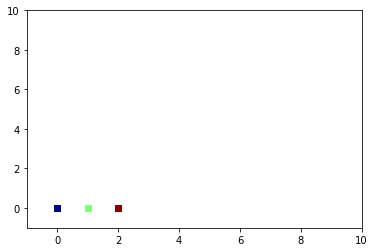

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65


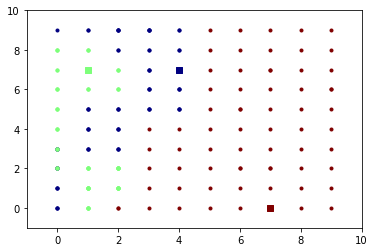

In [7]:
testHistory = []
server.reset_count()
planet = Planet(planet_width=planet_size, num_robots=num_robots)
colors = plt.cm.jet(np.linspace(0,1,num_robots))

# Trap Locations
tx, ty = [], []
# Generate Arrays for Robot Locations
locations_array = []
for r in range(num_robots):
    # Appends pasty, pastx, currety, currentx
    locations_array.append(([],[],[],[]))

for y, row in enumerate(planet.planet):
    for x, col in enumerate(row):
        if planet.planet[(y,x)] == 1:
            tx.append(x)
            ty.append(y)
            
# Intialise original positions
for r in range(num_robots):
    locations_array[r][0].append(planet.robot_positions[r][0])
    locations_array[r][1].append(planet.robot_positions[r][1])
    plt.scatter(locations_array[r][1], locations_array[r][0], marker='s', color=colors[r])
     
plt.xlim([-1, planet_size])
plt.ylim([-1, planet_size])   
plt.show()

vist_count = 0
action_history = []
#robot.random_factor = 0 # Only choose the best action
#Intialise Variables
movementBudget = Movement_Budget
server.reset_count()
# vist all starting locations
for r in range(num_robots):
    robot = swarm[r]
    robot.reset_backtrack()
    if planet.robot_positions[r] not in server.visited_locations:
        server.visited_locations.append(planet.robot_positions[r])
        server.no_visited_locations += 1

while not server.fully_covered:  
    for n in range(num_robots):
        robot = swarm[n]
        sHistory = robot.state_history
        #state, _ = planet.get_state_and_reward(sHistory, robot.robot_num, server.visited_locations) # get the current state
        state = planet.robot_positions[robot.robot_num]
        action, valid = robot.choose_action(state, planet.allowed_states[state], sHistory, planet, server.visited_locations) # choose an action (explore or exploit)
        if valid:
            planet.update_planet(action, robot.robot_num) # update the planet according to the action
            next_state, reward = planet.get_state_and_reward(sHistory, robot.robot_num, server.visited_locations) # get the new state and reward    
            robot.update_state_history(next_state, action)
            if next_state not in server.visited_locations:
                server.visited_locations.append(next_state)
                server.no_visited_locations += 1
                if server.no_visited_locations >= visitable_locations:
                    completed_count += 1
                    reward = 10
            robot.learn(state, reward, action, next_state, i, planet.planet_width)

    planet.steps += 1
    movementBudget -= 1        
    if server.no_visited_locations >= visitable_locations: 
        server.fully_covered = True
    elif movementBudget <= 0:
        # End the episode if the movement budget runs out
        server.fully_covered = True       

    # Get locations of robots for plotting    
    for r in range(num_robots):
        locations_array[r][0].append(planet.robot_positions[r][0])
        locations_array[r][1].append(planet.robot_positions[r][1])

for r in range(num_robots):
        locations_array[r][0].append(planet.robot_positions[r][0])
        locations_array[r][1].append(planet.robot_positions[r][1])
    
testHistory.append(planet.steps) # get a history of number of steps taken to plot later

fig, ax = plt.subplots()

def animate(i):
    print(i)
    plt.clf()
    plt.xlim([-1, planet_size])
    plt.ylim([-1, planet_size])
    plt.scatter(tx, ty, marker = 'x', color = 'r') 
    
    for r in range(num_robots):
        plt.scatter(locations_array[r][1][i], locations_array[r][0][i], marker = 's', color = colors[r]) 
        locations_array[r][2].append(locations_array[r][0][i])
        locations_array[r][3].append(locations_array[r][1][i])
        plt.scatter(locations_array[r][3], locations_array[r][2], marker = '.', color = colors[r])        
    return fig

ani = animation.FuncAnimation(fig, animate, repeat=True,
                                    frames=len(locations_array[r][0]) - 1, interval=500) 

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=3,
                             metadata=dict(artist='Me'),
                             bitrate=1800)
ani.save('path.gif', writer=writer)
plt.show()
        